In [17]:
%load_ext autoreload
%autoreload 2
from final_project.models import run_model
from final_project.models import save_model_pkl
from final_project.models import load_model
from final_project.models import plot_frequencies
import final_project.plots as plots
from final_project import builder
from final_project.loader import get_df
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

print(torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


In [18]:
# master_df = get_df(year="2018")
master_df = get_df(all_files=True)
master_df = master_df[master_df['Origin'] == 'BOS']
master_df = master_df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Year',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
master_df = builder.encodeFrame(master_df)
# delay_df = master_df[master_df['ArrDel15'] > 0.5].sample(n=4000)
# on_time_df = master_df[master_df['ArrDel15'] <= 0.5].sample(n=16000)
# master_df = pd.concat([delay_df, on_time_df], ignore_index=True)

# samples: 512522
train:
 - Number of features:  121
 - Number of samples:  384391
[311900  72491]


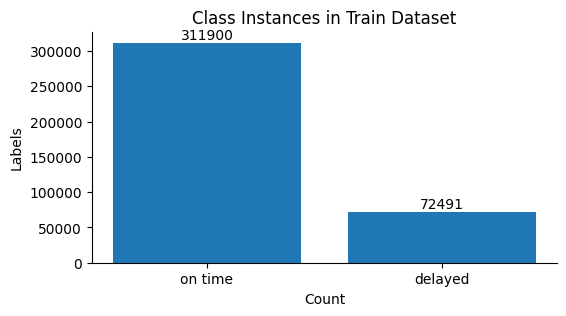


test:
 - Number of features:  121
 - Number of samples:  64065
[51980 12085]


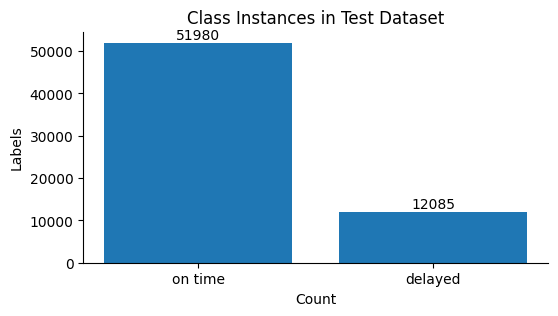


validation:
 - Number of features:  121
 - Number of samples:  64066
[52106 11960]


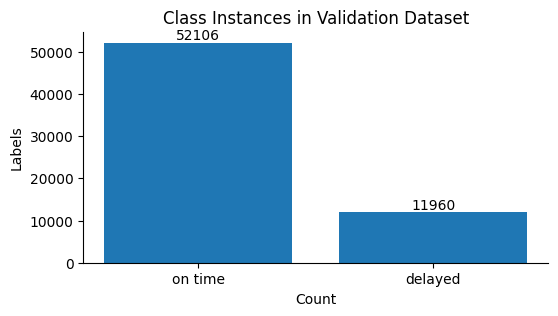

In [33]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_frequencies(each, (unique, counts))
    print()

In [34]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [35]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)
num_features=X_train.shape[1] 

using:  cpu


100%|██████████| 50/50 [13:24<00:00, 16.08s/it]

best loss:  0.2518855929374695
+---------------------------+----------+
| Hyperparameter            |    Value |
+===========================+==========+
| Best batch size:          |  64      |
+---------------------------+----------+
| Best epoch:               |  50      |
+---------------------------+----------+
| Best learning rate:       |   0.01   |
+---------------------------+----------+
| Best num nodes:           | 100      |
+---------------------------+----------+
| Best num layers:          |   4      |
+---------------------------+----------+
| Best momentum:            |   0.009  |
+---------------------------+----------+
| Best weight decay:        |   0.0001 |
+---------------------------+----------+
| Best dropout probability: |   0.25   |
+---------------------------+----------+


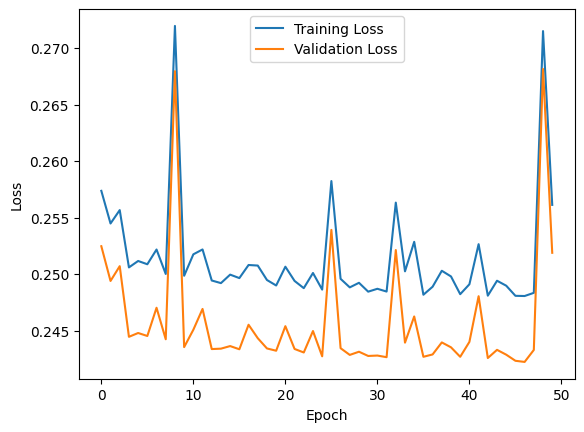

Evaluating **train** dataset:
using:  cpu


100%|██████████| 6007/6007 [00:05<00:00, 1019.78it/s]


Mean Accuracy: 92.553
Mean per-class accuracy:
  on time: 99.983%
  delayed: 60.584%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    311900
         1.0       1.00      0.61      0.75     72491

    accuracy                           0.93    384391
   macro avg       0.96      0.80      0.86    384391
weighted avg       0.93      0.93      0.92    384391

[[311847     53]
 [ 28573  43918]]

Evaluating **test** dataset:
using:  cpu


100%|█████████▉| 1001/1002 [00:01<00:00, 950.62it/s]


RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [36]:
params = {"bs":(64,),
        "epoch":(50,),
        "learning_rate":(.01,),
        "momentum":(.009,),
        "weight_decay":(.0001,),
        "activation_fn": nn.ReLU,
        "dropout_prob": (.25,),
        "num_layers": (4,),
        "num_nodes": (100,)}
best_model_params, best_model = run_model(param_dict=params, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  valid_ds=valid_ds,
                  num_features=num_features
                  )

In [37]:
ground_truth_labels, y_prob, y_pred = best_model.predict(test_ds)
plots.save_precision_recall_curve("ffn", "ffn_1_2_prec_rec_curve", ground_truth_labels, y_prob)
plots.save_confusion_matrix("ffn", "ffn_1_2_confusion", ground_truth_labels, y_pred)


using:  cpu


100%|█████████▉| 1001/1002 [00:00<00:00, 1089.82it/s]


RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [30]:
save_model_pkl(best_model_params)

In [ ]:
load_model()